In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries

from sklearn.preprocessing import MinMaxScaler

from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

2023-09-15 00:01:07.463294: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-15 00:01:07.703917: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-15 00:01:07.705276: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 00:01:08.722358: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
api_key = "MSUXUGI52VP00ZLX"

stock_symbol = 'AAPL'
start_date = '2000-01-01'
end_date = '2022-12-31'

ts = TimeSeries(key=api_key, output_format='pandas')

data, meta_data = ts.get_daily(symbol=stock_symbol, outputsize='full')

df = data[(data.index >= start_date) & (data.index <=end_date)]

df.head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2022-12-30,128.41,129.9500,127.43,129.93,77034209.0
2022-12-29,127.99,130.4814,127.73,129.61,75703710.0
2022-12-28,129.67,131.0275,125.87,126.04,85438391.0
2022-12-27,131.38,131.4100,128.72,130.03,69007830.0
2022-12-23,130.92,132.4150,129.64,131.86,63814893.0


In [3]:
df.tail()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2000-01-07,96.50,101.00,95.50,99.50,4113700.0
2000-01-06,106.12,107.00,95.00,95.00,6856900.0
2000-01-05,103.75,110.56,103.00,104.00,6949300.0
2000-01-04,108.25,110.62,101.19,102.50,4574800.0
2000-01-03,104.87,112.50,101.69,111.94,4783900.0


In [4]:
df.shape

(5787, 5)

In [5]:
df = df.reset_index()
df.head()

,date,1. open,2. high,3. low,4. close,5. volume
0,2022-12-30,128.41,129.9500,127.43,129.93,77034209.0
1,2022-12-29,127.99,130.4814,127.73,129.61,75703710.0
2,2022-12-28,129.67,131.0275,125.87,126.04,85438391.0
3,2022-12-27,131.38,131.4100,128.72,130.03,69007830.0
4,2022-12-23,130.92,132.4150,129.64,131.86,63814893.0


In [6]:
df = df.drop(['date'], axis=1)

In [7]:
df.head()

,1. open,2. high,3. low,4. close,5. volume
0,128.41,129.9500,127.43,129.93,77034209.0
1,127.99,130.4814,127.73,129.61,75703710.0
2,129.67,131.0275,125.87,126.04,85438391.0
3,131.38,131.4100,128.72,130.03,69007830.0
4,130.92,132.4150,129.64,131.86,63814893.0


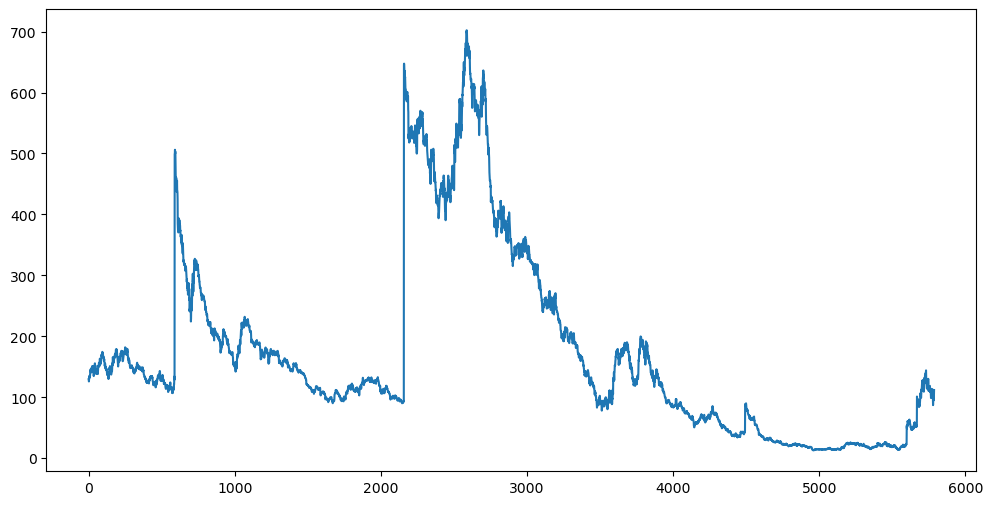

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df['4. close'])

In [9]:
ma100 = df['4. close'].rolling(100).mean()
ma100

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
5782    113.9880
5783    114.0980
5784    114.2624
5785    114.4237
5786    114.6704
Name: 4. close, Length: 5787, dtype: float64

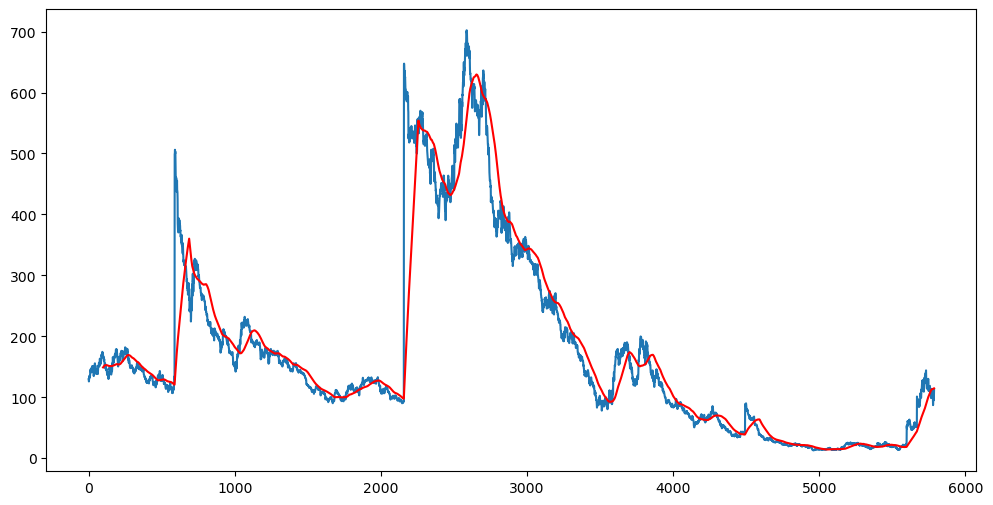

In [10]:
plt.figure(figsize = (12, 6))
plt.plot(df['4. close'])
plt.plot(ma100, 'r')

In [11]:
ma200 = df['4. close'].rolling(200).mean()
ma200

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
5782    84.11895
5783    84.49645
5784    84.92175
5785    85.33365
5786    85.79275
Name: 4. close, Length: 5787, dtype: float64

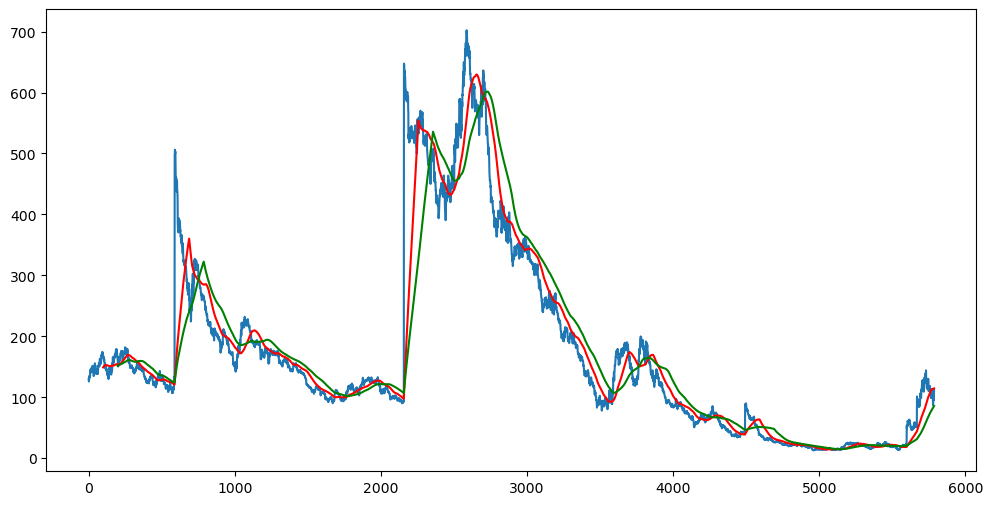

In [12]:
plt.figure(figsize = (12, 6))
plt.plot(df['4. close'])
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')

In [13]:
#Splitting data into Training and Testing

data_training = pd.DataFrame(df['4. close'] [0: int(len(df)*0.70)])
data_testing = pd.DataFrame(df['4. close'] [int(len(df)*0.70): len(df)])

print(data_training.shape)
print(data_testing.shape)

(4050, 1)
(1737, 1)


In [14]:
data_training.head()
data_testing.head()

,4. close
4050,91.81
4051,89.54
4052,91.63
4053,90.31
4054,88.60


In [15]:
# for using LSTM Model we have to scale down the data between 0 and 1
scaler = MinMaxScaler(feature_range = (0, 1))

data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.08291393],
       [0.08240103],
       [0.07667895],
       ...,
       [0.02102901],
       [0.02157397],
       [0.02179837]])

In [16]:
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [17]:
#ML Model

model = Sequential()

model.add(LSTM(units = 50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50)

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
124/124 [==============================] - 19s 124ms/step - loss: 0.0155
Epoch 2/100
124/124 [==============================] - 16s 129ms/step - loss: 0.0069
Epoch 3/100
124/124 [==============================] - 16s 126ms/step - loss: 0.0053
Epoch 4/100
124/124 [==============================] - 16s 126ms/step - loss: 0.0048
Epoch 5/100
124/124 [==============================] - 16s 127ms/step - loss: 0.0041
Epoch 6/100
124/124 [==============================] - 15s 123ms/step - loss: 0.0042
Epoch 7/100
124/124 [==============================] - 15s 125ms/step - loss: 0.0039
Epoch 8/100
124/124 [==============================] - 15s 122ms/step - loss: 0.0037
Epoch 9/100
124/124 [==============================] - 15s 125ms/step - loss: 0.0036
Epoch 10/100
124/124 [==============================] - 16s 128ms/step - loss: 0.0034
Epoch 11/100
124/124 [==============================] - 16s 129ms/step - loss: 0.0035
Epoch 12/100
124/124 [==============================] - 16s 129

124/124 [==============================] - 16s 128ms/step - loss: 0.0020
Epoch 97/100
124/124 [==============================] - 16s 128ms/step - loss: 0.0023
Epoch 98/100
124/124 [==============================] - 16s 126ms/step - loss: 0.0023
Epoch 99/100
124/124 [==============================] - 16s 126ms/step - loss: 0.0022
Epoch 100/100
124/124 [==============================] - 16s 125ms/step - loss: 0.0021


In [20]:
model.save('my_model1.keras')

In [21]:
data_testing.head()

,4. close
4050,91.81
4051,89.54
4052,91.63
4053,90.31
4054,88.60


In [22]:
past_100_days = data_training.tail(100)

In [23]:
final_df = past_100_days._append(data_testing, ignore_index=True)
final_df.head()

,4. close
0,95.348
1,93.240
2,93.510
3,90.970
4,90.270


In [24]:
input_data = scaler.fit_transform(final_df)
input_data.shape

(1837, 1)

In [25]:
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i, 0])


In [26]:
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(1737, 100, 1)
(1737,)


In [27]:
#Making Predictions

y_predicted = model.predict(x_test)
y_predicted.shape
y_test
y_predicted

55/55 [==============================] - 3s 39ms/step


array([[0.50612485],
       [0.5081557 ],
       [0.5045169 ],
       ...,
       [0.5769079 ],
       [0.5924048 ],
       [0.6003513 ]], dtype=float32)

In [28]:
scaler.scale_

array([0.00762951])

In [29]:
scale_factor = 1/0.00762951
y_predicted = y_predicted*scale_factor
y_test = y_test * scale_factor

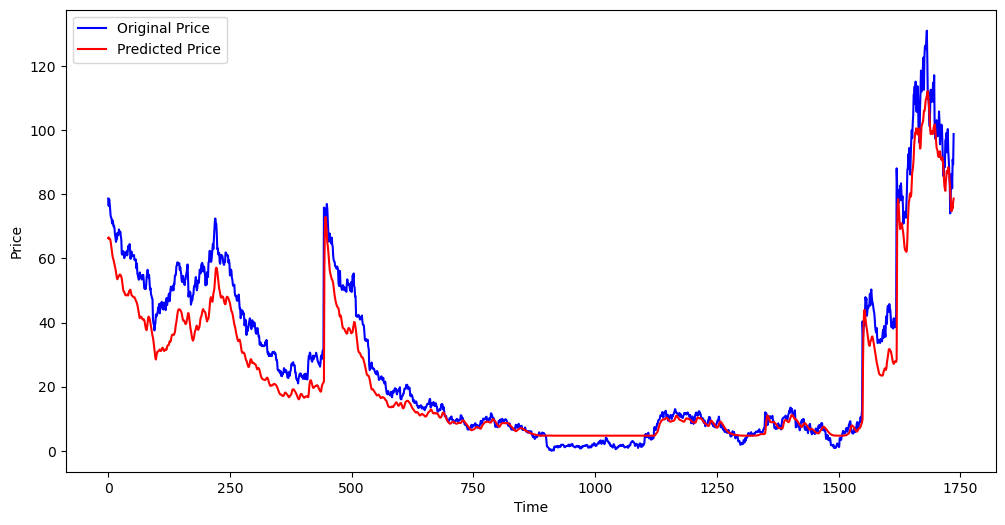

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'b', label="Original Price")
plt.plot(y_predicted, 'r', label="Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()